### Necessaires

In [1]:
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch
from functools import partial
#from . import get_sigmas
from layers import *
from normalization import get_normalization

In [23]:
# title NCSNv2Deeper 

class NCSNv2Deeper(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.logit_transform = config.data.logit_transform
        self.rescaled = config.data.rescaled
        self.norm = get_normalization(config, conditional=False)
        self.ngf = ngf = config.model.ngf
        self.num_classes = config.model.num_classes
        self.act = act = get_act(config)
        self.register_buffer('sigmas', get_sigmas(config))
        self.config = config
        

        self.begin_conv = nn.Conv2d(config.data.channels, ngf, 3, stride=1, padding=1)
        self.normalizer = self.norm(ngf, self.num_classes)

        self.end_conv = nn.Conv2d(ngf, config.data.channels, 3, stride=1, padding=1)

        self.res1 = nn.ModuleList([
            ResidualBlock(self.ngf, self.ngf, resample=None, act=act,
                          normalization=self.norm),
            ResidualBlock(self.ngf, self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res2 = nn.ModuleList([
            ResidualBlock(self.ngf, 2 * self.ngf, resample='down', act=act,
                          normalization=self.norm),
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res3 = nn.ModuleList([
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample='down', act=act,
                          normalization=self.norm),
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res4 = nn.ModuleList([
            ResidualBlock(2 * self.ngf, 4 * self.ngf, resample='down', act=act,
                          normalization=self.norm, dilation=2),
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample=None, act=act,
                          normalization=self.norm, dilation=2)]
        )

        self.res5 = nn.ModuleList([
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample='down', act=act,
                          normalization=self.norm, dilation=4),
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample=None, act=act,
                          normalization=self.norm, dilation=4)]
        )

        self.refine1 = RefineBlock([4 * self.ngf], 4 * self.ngf, act=act, start=True)
        self.refine2 = RefineBlock([4 * self.ngf, 4 * self.ngf], 2 * self.ngf, act=act)
        self.refine3 = RefineBlock([2 * self.ngf, 2 * self.ngf], 2 * self.ngf, act=act)
        self.refine4 = RefineBlock([2 * self.ngf, 2 * self.ngf], self.ngf, act=act)
        self.refine5 = RefineBlock([self.ngf, self.ngf], self.ngf, act=act, end=True)

    def _compute_cond_module(self, module, x):
        for m in module:
            x = m(x)
        return x

    def forward(self, x, y):
        if not self.logit_transform and not self.rescaled:
            h = 2 * x - 1.
        else:
            h = x

        output = self.begin_conv(h)

        layer1 = self._compute_cond_module(self.res1, output)
        layer2 = self._compute_cond_module(self.res2, layer1)
        layer3 = self._compute_cond_module(self.res3, layer2)
        layer4 = self._compute_cond_module(self.res4, layer3)
        layer5 = self._compute_cond_module(self.res5, layer4)

        ref1 = self.refine1([layer5], layer5.shape[2:])
        ref2 = self.refine2([layer4, ref1], layer4.shape[2:])
        ref3 = self.refine3([layer3, ref2], layer3.shape[2:])
        ref4 = self.refine4([layer2, ref3], layer2.shape[2:])
        output = self.refine5([layer1, ref4], layer1.shape[2:])

        output = self.normalizer(output)
        output = self.act(output)
        output = self.end_conv(output)

        used_sigmas = self.sigmas[y.long()].view(x.shape[0], *([1] * len(x.shape[1:])))

        output = output / used_sigmas

        return output


In [24]:
import yaml

# Load the YAML file as a dictionary
with open("configs.yml", "r") as file:
    config_dict = yaml.safe_load(file)

# Access the elements of the dictionary using dot notation
class Config:
    def __init__(self, d):
        self.training = Config.Training(d["training"])
        self.sampling = Config.Sampling(d["sampling"])
        self.fast_fid = Config.FastFID(d["fast_fid"])
        self.test = Config.Test(d["test"])
        self.data = Config.Data(d["data"])
        self.model = Config.Model(d["model"])
        self.optim = Config.Optim(d["optim"])
    class Training:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.n_epochs = d["n_epochs"]
            self.n_iters = d["n_iters"]
            self.snapshot_freq = d["snapshot_freq"]
            self.snapshot_sampling = d["snapshot_sampling"]
            self.anneal_power = d["anneal_power"]
            self.log_all_sigmas = d["log_all_sigmas"]

    class Sampling:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.data_init = d["data_init"]
            self.step_lr = d["step_lr"]
            self.n_steps_each = d["n_steps_each"]
            self.ckpt_id = d["ckpt_id"]
            self.final_only = d["final_only"]
            self.fid = d["fid"]
            self.denoise = d["denoise"]
            self.num_samples4fid = d["num_samples4fid"]
            self.inpainting = d["inpainting"]
            self.interpolation = d["interpolation"]
            self.n_interpolations = d["n_interpolations"]

    class FastFID:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.num_samples = d["num_samples"]
            self.step_lr = d["step_lr"]
            self.n_steps_each = d["n_steps_each"]
            self.begin_ckpt = d["begin_ckpt"]
            self.end_ckpt = d["end_ckpt"]
            self.verbose = d["verbose"]
            self.ensemble = d["ensemble"]

    class Test:
        def __init__(self, d):
            self.begin_ckpt = d["begin_ckpt"]
            self.end_ckpt = d["end_ckpt"]
            self.batch_size = d["batch_size"]

    class Data:
        def __init__(self, d):
            self.dataset = d["dataset"]
            self.image_size = d["image_size"]
            self.channels = d["channels"]
            self.logit_transform = d["logit_transform"]
            self.uniform_dequantization = d["uniform_dequantization"]
            self.gaussian_dequantization = d["gaussian_dequantization"]
            self.random_flip = d["random_flip"]
            self.rescaled = d["rescaled"]
            self.num_workers = d["num_workers"]

    class Model:
        def __init__(self, d):
            self.sigma_begin = d["sigma_begin"]
            self.num_classes = d["num_classes"]
            self.ema = d["ema"]
            self.ema_rate = d["ema_rate"]
            self.spec_norm = d["spec_norm"]
            self.sigma_dist = d["sigma_dist"]
            self.sigma_end = d["sigma_end"]
            self.normalization = d["normalization"]
            self.nonlinearity = d["nonlinearity"]
            self.ngf = d["ngf"]

    class Optim:
        def __init__(self, d):
            self.weight_decay = d["weight_decay"]
            self.optimizer = d["optimizer"]
            self.lr = d["lr"]
            self.beta1 = d["beta1"]
            self.amsgrad = d["amsgrad"]
            self.eps = d["eps"]

    


# Create a config object
config = Config(config_dict)

In [25]:
def anneal_dsm_score_estimation(scorenet, samples, sigmas, labels=None, anneal_power=2., hook=None):
    if labels is None:
        labels = torch.randint(0, len(sigmas), (samples.shape[0],), device=samples.device)
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    noise = torch.randn_like(samples) * used_sigmas
    perturbed_samples = samples + noise
    target = - 1 / (used_sigmas ** 2) * noise
    scores = scorenet(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power

    if hook is not None:
        hook(loss, labels)

    return loss.mean(dim=0)

In [8]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import numpy as np
from torchvision.datasets import ImageFolder


dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
subset_size = 2000  # The number of samples you want in the subset
indices = np.random.choice(len(train_dataset), subset_size, replace=False)
svhn_train_subset = Subset(train_dataset, indices)

dataloader = DataLoader(svhn_train_subset, batch_size=64, shuffle=True, num_workers=4)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1058491962.py, line 6)

In [26]:
def get_sigmas(config):
    if config.model.sigma_dist == 'geometric':
        sigmas = torch.tensor(
            np.exp(np.linspace(np.log(config.model.sigma_begin), np.log(config.model.sigma_end),
                               config.model.num_classes))).float()#.to(config.device)
    elif config.model.sigma_dist == 'uniform':
        sigmas = torch.tensor(
            np.linspace(config.model.sigma_begin, config.model.sigma_end, config.model.num_classes)
        ).float()#.to(config.device)

    else:
        raise NotImplementedError('sigma distribution not supported')

    return sigmas

In [27]:
import torch
from torch.optim import Adam

# Instantiate the model
model = NCSNv2Deeper(config)

# Move the model to the desired device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the optimizer
optimizer = Adam(model.parameters(), lr=config.optim.lr)

# Define the number of training epochs
n_epochs = config.training.n_epochs

# Define the sigmas
sigmas = get_sigmas(config)

### Sampling

In [28]:
#@title Set up the SDE
import functools

from functools import partial, reduce


device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  10.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [32]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=1, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cpu', 
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation 
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 3, 224, 224, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

In [49]:
def anneal_Langevin_dynamics(x_mod, scorenet, sigmas, n_steps_each=3, step_lr=0.000008,
                             final_only=False, verbose=False, denoise=True):
    images = []

    with torch.no_grad():
        for c, sigma in enumerate(sigmas):
            labels = torch.ones(x_mod.shape[0], device=x_mod.device) * c
            labels = labels.long()
            step_size = step_lr * (sigma / sigmas[-1]) ** 2
            for s in range(n_steps_each):
                grad = scorenet(x_mod, labels)

                noise = torch.randn_like(x_mod)
                grad_norm = torch.norm(grad.view(grad.shape[0], -1), dim=-1).mean()
                noise_norm = torch.norm(noise.view(noise.shape[0], -1), dim=-1).mean()
                x_mod = x_mod + step_size * grad + noise * np.sqrt(step_size * 2)

                image_norm = torch.norm(x_mod.view(x_mod.shape[0], -1), dim=-1).mean()
                snr = np.sqrt(step_size / 2.) * grad_norm / noise_norm
                grad_mean_norm = torch.norm(grad.mean(dim=0).view(-1)) ** 2 * sigma ** 2

                if not final_only:
                    images.append(x_mod.to('cpu'))
                if verbose:
                    print("level: {}, step_size: {}, grad_norm: {}, image_norm: {}, snr: {}, grad_mean_norm: {}".format(
                        c, step_size, grad_norm.item(), image_norm.item(), snr.item(), grad_mean_norm.item()))

        if denoise:
            last_noise = (len(sigmas) - 1) * torch.ones(x_mod.shape[0], device=x_mod.device)
            last_noise = last_noise.long()
            x_mod = x_mod + sigmas[-1] ** 2 * scorenet(x_mod, last_noise)
            images.append(x_mod.to('cpu'))

        if final_only:
            return [x_mod.to('cpu')]
        else:
            return images

In [50]:
def logit_transform(image, lam=1e-6):
    image = lam + (1 - 2 * lam) * image
    return torch.log(image) - torch.log1p(-image)

In [51]:
## Random state will be affected because of sampling during training time.
init_samples = torch.rand(36, 3,
                          32, 32,
                          device=device)



In [52]:
init_samples = logit_transform(init_samples, init_samples)

In [53]:
ema_helper = EMAHelper(mu=0.999)


In [54]:
score = NCSNv2Deeper

In [45]:
#test_score = ema_helper.ema_copy(score)

AttributeError: type object 'NCSNv2Deeper' has no attribute 'config'

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [56]:
device

'cpu'

In [57]:
ckpt = torch.load('trained_model.pth', map_location=device)
model.load_state_dict(ckpt)

all_samples = anneal_Langevin_dynamics(init_samples, model, sigmas.cpu().numpy(),
                                                               5,
                                                               0.0000062,
                                                               final_only=True, verbose=True,
                                                               denoise=True)

sample = all_samples[-1].view(all_samples[-1].shape[0], 3,
                                                      32,
                                                      32)

level: 0, step_size: 155.0, grad_norm: 0.22254416346549988, image_norm: 976.7904663085938, snr: 0.03535411134362221, grad_mean_norm: 38.017765045166016
level: 0, step_size: 155.0, grad_norm: 0.9957568049430847, image_norm: 1274.8489990234375, snr: 0.15835152566432953, grad_mean_norm: 68.8056869506836
level: 0, step_size: 155.0, grad_norm: 1.0381171703338623, image_norm: 1483.3431396484375, snr: 0.16481472551822662, grad_mean_norm: 75.15415954589844
level: 0, step_size: 155.0, grad_norm: 1.0596909523010254, image_norm: 1641.55517578125, snr: 0.1685824990272522, grad_mean_norm: 79.47726440429688
level: 0, step_size: 155.0, grad_norm: 1.0703235864639282, image_norm: 1770.179443359375, snr: 0.16985203325748444, grad_mean_norm: 80.68477630615234
level: 1, step_size: 143.98126408773226, grad_norm: 1.1188561916351318, image_norm: 1865.513427734375, snr: 0.17114606499671936, grad_mean_norm: 81.7657241821289
level: 1, step_size: 143.98126408773226, grad_norm: 1.1258436441421509, image_norm: 194

In [61]:

import numpy as np

# Assuming your list of tensors is named 'all_samples'
for i, tensor in enumerate(all_samples):
    output_tensor_str = np.array2string(tensor.numpy(), separator=', ', precision=8, suppress_small=True)

    # Save the string representation to a text file
    with open(f'output_tensor_{i}.txt', 'w') as f:
        f.write(output_tensor_str)



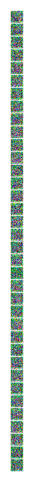

In [58]:
## Sample visualization.
samples = sample.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


sample_batch_size = 1

sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)), padding=2, pad_value=1)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

### MNIST generating

C:\Users\miche\AppData\Local\Temp\ipykernel_25360\3912911741.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
C:\Users\miche\AppData\Local\Temp\ipykernel_25360\3912911741.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 32


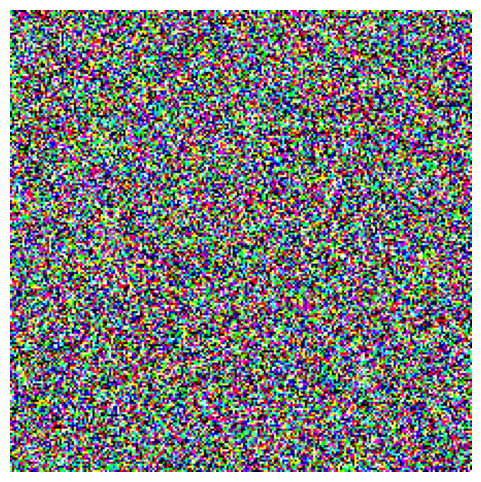

In [31]:
from torchvision.utils import make_grid
sigma = 0.1
## Load the pre-trained checkpoint from disk.
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('trained_model.pth', map_location=device)
model.load_state_dict(ckpt)

sample_batch_size = 1 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt

sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)), padding=2, pad_value=1)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [41]:
class EMAHelper(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        if isinstance(module, nn.DataParallel):
            inner_module = module.module
            module_copy = type(inner_module)(inner_module.config).to(inner_module.config.device)
            module_copy.load_state_dict(inner_module.state_dict())
            module_copy = nn.DataParallel(module_copy)
        else:
            module_copy = type(module)(module.config).to(module.config.device)
            module_copy.load_state_dict(module.state_dict())
        # module_copy = copy.deepcopy(module)
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict